In [1]:
import torch
import clip
from PIL import Image
import pandas as pd
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

train_csv_path = "data\labels\label_final_train.tsv"
val_csv_path = "data\labels\label_final_val.tsv"
test_csv_path = "data\labels\label_final_test.tsv"

image_root = "data\images"
num_samples = 200

# Prompts
class_map = {
    "0" : "This is irrelevant",
    "1" : "This is no damage",
    "2" : "This is mild damage",
    "3" : "This is severe damage"
}

class_names = list(class_map.keys())
text_prompts = [class_map[c] for c in class_names]
text_tokens = clip.tokenize(text_prompts).to(device)

In [2]:
train_df = pd.read_csv(train_csv_path, sep="\t")
val_df = pd.read_csv(val_csv_path, sep="\t")
test_df = pd.read_csv(test_csv_path, sep="\t")
df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)
df

,image_path,damage_severity
0,118292.jpg,3
1,nepal_eq_none_im_18608.jpg,0
2,nepal_eq_severe_im_41646.jpg,3
3,yemencrisis_2017-09-09_12-19-58.jpg,3
4,nepal_eq_none_im_23781.jpg,1
...,...,...
13508,nepal_eq_severe_im_35571.jpg,3
13509,nepal_eq_severe_im_37980.jpg,3
13510,593160383990472704_0.png,3
13511,593767686842093571_2.jpg,3


In [3]:
y_true = []
y_pred = []

for i, row in df.iterrows():
    img_path = os.path.join(image_root, row['image_path'])
    true_label = str(row['damage_severity'])

    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_tokens)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarity = (image_features @ text_features.T).squeeze(0)
        predicted_index = similarity.argmax().item()
        predicted_label = class_names[predicted_index]
    
    print(f"[{i+1:02d}] True: {class_map[true_label]:25} | Pred: {class_map[predicted_label]}")
    y_true.append(true_label)
    y_pred.append(predicted_label)

[01] True: This is severe damage     | Pred: This is mild damage
[02] True: This is irrelevant        | Pred: This is no damage
[03] True: This is severe damage     | Pred: This is mild damage
[04] True: This is severe damage     | Pred: This is mild damage
[05] True: This is no damage         | Pred: This is severe damage
[06] True: This is severe damage     | Pred: This is no damage
[07] True: This is irrelevant        | Pred: This is mild damage
[08] True: This is severe damage     | Pred: This is mild damage
[09] True: This is irrelevant        | Pred: This is mild damage
[10] True: This is no damage         | Pred: This is no damage
[11] True: This is mild damage       | Pred: This is severe damage
[12] True: This is no damage         | Pred: This is severe damage
[13] True: This is severe damage     | Pred: This is severe damage
[14] True: This is severe damage     | Pred: This is mild damage
[15] True: This is no damage         | Pred: This is severe damage
[16] True: This is se


📊 Classification Report:
                       precision    recall  f1-score   support

   This is irrelevant       0.52      0.11      0.18      2855
    This is no damage       0.41      0.38      0.39      3629
  This is mild damage       0.03      0.28      0.06       474
This is severe damage       0.46      0.38      0.42      6555

             accuracy                           0.32     13513
            macro avg       0.36      0.29      0.26     13513
         weighted avg       0.44      0.32      0.35     13513



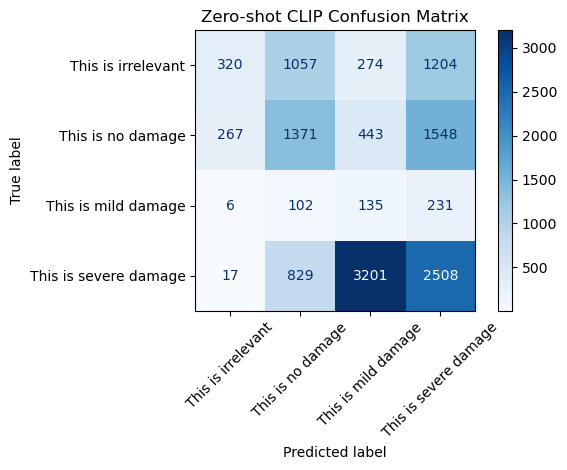

<Figure size 640x480 with 0 Axes>

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=[class_map[c] for c in class_names]))

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_map[c] for c in class_names])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Zero-shot CLIP Confusion Matrix")
plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix.png", dpi=300)
